In [6]:
#packages
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import scipy as sp
import random

from scipy import signal
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, close, subplots, title, savefig, get_current_fig_manager, show, pause, clf

Synthetic data generation is a common method in computational neuroscience. In general, synthetic data generation strength is that it enables researchers to develop a robust algorithmic solution for solving a specific problem. Generating synthetic data is mostly a bottom-up process, whereas data analysis is a top-down process. Given the nature of synthetic data, even if the analysing algorithm is not sufficient, there will always be a room for manipulating and deconstructing the data in order to understrand the potential weaknesses of our analysing tools then improve them, which is clearly not the with real world data. Nonetheless, instantly analysing a real world data set can also lead us satisfying conclusions, a well developed algorithm can be later modified on real data so the potential risk of having false conclusions is less higher.

Based on this idea, the synthetic data generation starts with the bottom element or the primal focus of the research, which are independent dendritic events in this case. As it is stated above, the neuronal recording of the CA3 neurons catch the cell activity marked by the fluorescent liquid. To simulate this, first I generate synthetic somatic (A and B soma) and dendritic (dendrite of A soma) spike trains then convolve it. Secondary, I create rectangles that attempts to simulate a low resolution frame of recording a soma, its dendrites and a second soma whichs to some extent overlaps the dendrite. Lastly, taking the outer product of the spike trains and the frames leads us to a neuronal record simulation. To specify this, I in the following section I would like to introdue the generated data for my research.

## Spike trains

For neural spike generation I implement a randomized poission process. Poission process consists of events within a specific time frequency. On real neural recordings we observed relatively low frequency activity, therefore I have defined fr_Soma = 0.2 for soma A and fr_Dendrite = fr / 0.5 spike frequency in an 15 mins sequence (with 1/30 number of bins - dt), which results at the total of 27000 timebins (nBins). To randomize the events this, I use np.random.rand() function from the Numpy package. This function generates random integers in the specified time range (nBins) and we can specifiy the events in time by defining the largest number (fr_Soma or fr_Dendrite multyplied by dt) that the function can return below.

In [7]:
np.random.seed(45)

fr = 0.05 # frequency
fr_2 = fr/1.2 # frequency
dt = 1/30.0; # s
Tmax = 900 # s
t = np.arange(0, Tmax, dt)
nBins = np.round(Tmax / dt).astype(int) # 5 min spike train
nTrials = 1; # Number of trials
myPoissonSpikeTrain_1 = np.random.rand(1,nBins) < fr*dt; # Poisson spike train built by logical values
spikes_a = myPoissonSpikeTrain_1.flatten()*1 # convert to np.array

myPoissonSpikeTrain_2 = np.random.rand(1,nBins) < fr_2*dt; # Poission spike train built by logical values
spikes_a_dend = myPoissonSpikeTrain_2.flatten()*1 # convert to np.array

myPoissonSpikeTrain_3 = np.random.rand(1,nBins) < fr*dt; # Poission spike train built by logical values
spikes_b = myPoissonSpikeTrain_3.flatten()*1 # convert to np.array


#time
time_scale = np.linspace(0,Tmax,10) # 15 min timebin
tcks = list(np.linspace(0,len(spikes_a), 10))
time_scale = time_scale.astype(int)

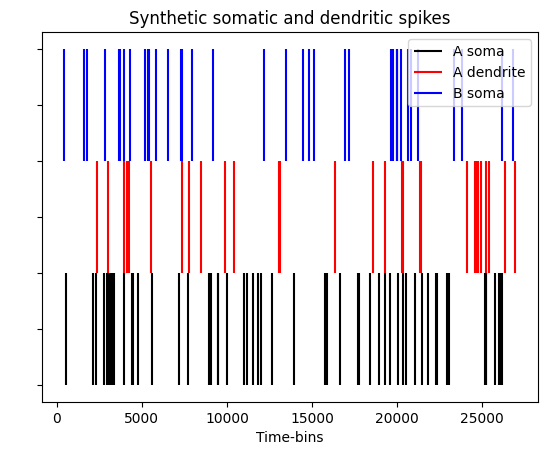

In [8]:
asspikes = plt.vlines(np.flatnonzero(spikes_a), 0, 1, 'k')
adspikes = plt.vlines(np.flatnonzero(spikes_a_dend), 1, 2, 'r')
bsspikes = plt.vlines(np.flatnonzero(spikes_b), 2, 3, 'b')
plt.title('Synthetic somatic and dendritic spikes')
plt.xlabel('Time-bins')
#plt.xticks(ticks = tcks, labels = time_scale)
plt.yticks(color='w')
plt.legend([asspikes,adspikes,bsspikes], ['A soma', 'A dendrite', 'B soma'])
plt.show()

Total number of spikes:

In [9]:
a_num_spikes = np.size(np.where(spikes_a))
a_dend_num_spikes = np.size(np.where(spikes_a_dend))
b_num_spikes = np.size(np.where(spikes_b))
insum = a_num_spikes + a_dend_num_spikes + b_num_spikes

For simulating the time consuming process wherein fluorescent fluid carried CA2+ molecules flows out to the extracellular space, I have to add realistic decays to the neural spikes. To implement this, I define the following convolutional kernel: exp(time/tau) - tau = 2, time = 300. For convolution mode I used valid mode, since keeping the initial dimenions are not important. After tthe convolution we use the results as synthetic fluorescent signals.

Also in the next cell I add baseline fluctuation and specifiy the power of the baseline to have roughly the same values like the original data possess. 

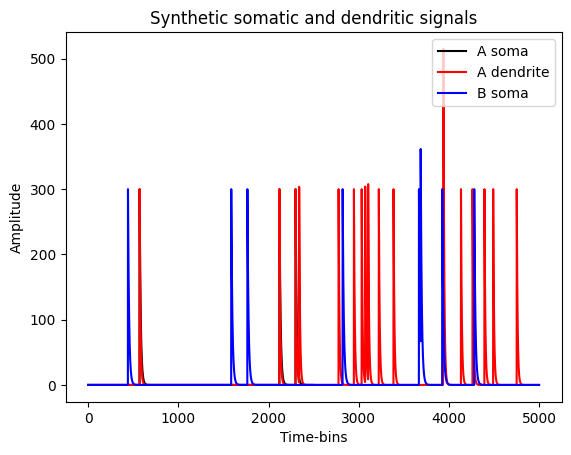

In [10]:
#causal_conv_ker ?
np.random.seed(85)
Lmax = 900
tt = np.arange(Lmax) / 30.0
tau_soma = 0.4
convker_soma = np.exp(-tt/tau_soma)
tau_dend = 0.3
convker_dend = np.exp(-tt/tau_dend)

# convolution
dF_a_soma = np.convolve(np.hstack((np.zeros(Lmax-1), spikes_a)), convker_soma, mode='valid') * 300
dF_a_dend = np.convolve(np.hstack((np.zeros(Lmax-1), spikes_a + spikes_a_dend)), convker_dend, mode='valid') * 300
dF_b_soma = np.convolve(np.hstack((np.zeros(Lmax-1), spikes_b)), convker_soma, mode='valid') * 300

# save the clean signals(without fluctuation)
# dF_a_soma_save = np.save('synthetic_dF_a_soma', dF_a_soma_clean)
# dF_a_dend_save = np.save('synthetic_dF_a_dend', dF_a_dend_clean)
# dF_b_soma_save = np.save('synthetic_dF_b_soma', dF_b_soma_clean)

# dF_a_soma = dF_a_soma.reshape(27000)
# dF_a_dend = dF_a_dend.reshape(27000)
# dF_b_soma = dF_b_soma.reshape(27000)

asomplot, = plt.plot(dF_a_soma[0:2500], 'k')
adendplot, = plt.plot(dF_a_dend[0:5000], '-r')
bsomplot, = plt.plot(dF_b_soma[0:5000], '-b')
plt.title('Synthetic somatic and dendritic signals')
plt.xlabel('Time-bins')
plt.ylabel('Amplitude')
plt.legend([asomplot,adendplot,bsomplot], ['A soma', 'A dendrite', 'B soma'], loc = 'upper right')
plt.show()
#plt.xlim(0, 50)

In [11]:
len_dF = len(dF_a_soma)

Next, I generate 36 pixel large rectangles (40x40 for somas, 20x50 for the dendrite) inside a 100x100 shape pictures.

## Generated images

In [12]:
x_1 = np.zeros(100)
x_1[11:51] = 1
y_1 = np.zeros(100)
y_1[10:50] = 1

x_2 = np.zeros(100)
x_2[51:81] = 1
y_2 = np.zeros(100)
y_2[20:35] = 1

x_3 = np.zeros(100)
x_3[51:91] = 1
y_3 = np.zeros(100)
y_3[21:61] = 1 # was 30:69

In [13]:
a_soma = np.outer(x_1, y_1)
dendrites = np.outer(x_2,y_2)
b_soma = np.outer(x_3,y_3)

masks = a_soma + 2*dendrites + 4*b_soma

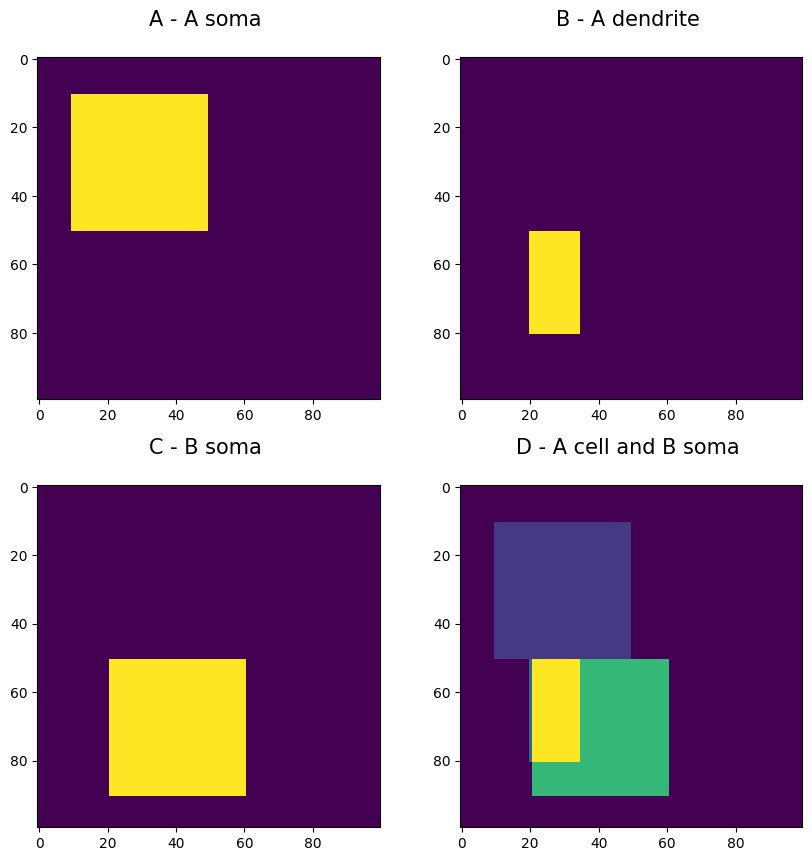

In [14]:
fig = plt.figure(figsize=(10, 10))

rows = 2
columns = 2

plt.subplots_adjust(hspace=0.25)

#1
fig.add_subplot(rows, columns, 1)
plt.imshow(a_soma)
plt.title('A - A soma \n', fontsize = 15)

#2
fig.add_subplot(rows, columns, 2)
plt.imshow(dendrites)
plt.title('B - A dendrite \n', fontsize = 15)

#3
fig.add_subplot(rows, columns, 3)
plt.imshow(b_soma)
plt.title('C - B soma \n', fontsize = 15)

#4
fig.add_subplot(rows, columns, 4)
plt.imshow(masks)
plt.title('D - A cell and B soma \n', fontsize = 15)

masks_save = np.save('masks', masks)
asoma_save = np.save('asomabase', a_soma)
adendrite_save = np.save('adendritebase', dendrites)
bsoma_save = np.save('bsomabase', b_soma)

For having a realistic neuronal sequence we have to take the outer product of the signals and the generated pictures, which results in three 2700x200 matrices.

## Synthetic frames

In [15]:
a_soma_flat = a_soma.flatten()*1
dendrites_flat = dendrites.flatten()*1
b_soma_flat = b_soma.flatten()*1

a_soma_frames = np.outer(a_soma_flat, dF_a_soma)
dendrites_frames = np.outer(dendrites_flat, dF_a_dend)
b_soma_frames = np.outer(b_soma_flat, dF_b_soma)

In [16]:
# f, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 6))

# #1
# axs[0].imshow(a_soma_frames[:,:], cmap='Greys', aspect = 'auto')
# axs[0].set_xlim(0, len_dF)

# #2
# axs[1].imshow(dendrites_frames[:,:], cmap='Greys', aspect = 'auto')
# axs[1].set_xlim(0, len_dF)
# #3
# axs[2].imshow(b_soma_frames[:,:], cmap='Greys', aspect = 'auto')
# axs[2].set_xlim(0, len_dF)

I add realistic noise to the signals by using the paramteres (location/mean = 10, sigma/standard deviation = 20) extracted by the noise analysis and recreate it by np.random.normal fucntion that calls a normal distribution of random numbers given the latter paramteres. After this, I concetanate the matrices into one 1500x40 size matrix.

In [17]:
noise = np.random.normal(loc=400, scale=60, size = (10000, nBins))

In order to have a full 3D data, the reshape of 1500x40 size matrix to 1500x20x20 tensor is required.

In [18]:
dFdemo = a_soma_frames + dendrites_frames + b_soma_frames
dF0 = a_soma_frames + dendrites_frames + b_soma_frames + noise # add the matrices + add noise
dF = dF0.reshape((100,100, len_dF))

In [19]:
# f, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 3))
# axs.imshow((dF0[:,:]+1), cmap='Greys_r', aspect = 'auto')
# axs.get_xaxis().set_visible(False)
# axs.get_yaxis().set_visible(False)

In the following section I would like to introduce that data analysis method that was built and optimized on the previous dataset. The method has three major parts. In the first part I define the mask coordinate of the region of interest, which for simplicity, are the coordinates of the synthetic somas and dendrites. In the second part, I use the masks to extract the fluorescent signals then filter the signals with convolving them by a moving Gauss-window - theoretically the more we increase the value of sigma the more high frequency signal ranges can be filtered out, which results in smoothened signal with less high  noise fluctuations (noise tipically exist in high frequency ranges). Finally, in the last part I developed a simple event detection function that detects the events above a specific threshold (theta_upper) and refracterize remaining part of the signal array until it reaches a secondary threshold (theta_lower), which is set below the signal orginal signal detector. 

## Masks on synthetic data:

In [20]:
#orginial mask coordinates

a_soma_mask = np.array(np.where(a_soma == 1))

a_dend_mask = np.array(np.where(dendrites == 1))

b_soma_mask = np.array(np.where(b_soma == 1))

In [21]:
# a_soma_mask_list = a_soma_mask.tolist()
# a_dend_mask_list = a_dend_mask.tolist()
# b_soma_mask_list = b_soma_mask.tolist()

synthetic_roi_masks = [a_soma_mask, a_dend_mask, b_soma_mask]

## DF on synthetic data

In [22]:
i_mask = 0
mask = synthetic_roi_masks[i_mask]
L_mask = mask.shape[0]
signal = np.zeros(dF.shape[2])
for i_pixel in np.arange(L_mask):
    pix = mask[:,i_pixel]
    signal = signal + dF[pix[0], pix[1],:]
signal1 = signal / L_mask

Text(0, 0.5, 'Signal amplitude')

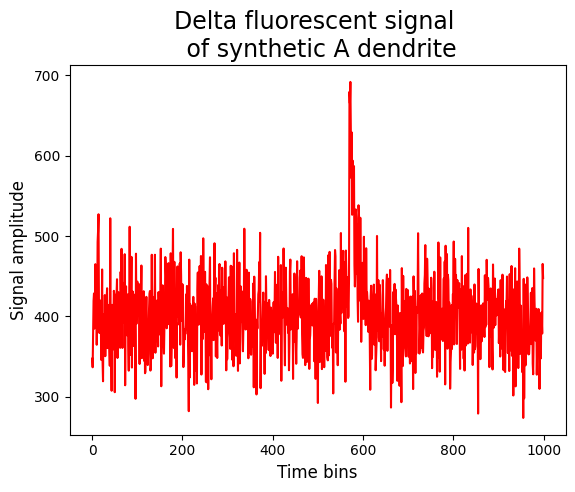

In [25]:
plt.plot(signal1[0:1000], 'r')
plt.title('Delta fluorescent signal \n of synthetic A dendrite', fontsize = 17)
plt.xlabel('Time bins', fontsize = 12)
plt.ylabel('Signal amplitude', fontsize = 12)

## DFpF

For extracting the fluorescent signals, in the first part, an empty tensor with the shape of the original array (27000x100x100) is created where the masks are placed identically to the original data tensor and has been filled up with the original signals. Theoretically, by using the overlaping masks it should return the noise contaminated signals of the somas and dendrites, which latter one is also contaminated by the acitivity of the somas. In the second part, the signals has to be subtracted by its median, then the result of this operation needs to divided by their median value to set them on the same baseline (DFpF). Also their maximum has to be subtracted from one in order to standardize their amplitude value.

In [20]:
def ROI_std(mask_number):
    mask_array  = synthetic_roi_masks.copy()
    j_mask = mask_number
    mask_ = mask_array[j_mask]
    L_mask_ = mask_.shape[0]
    signal_ = np.zeros(dF.shape[2])
    for j_pixel in np.arange(L_mask_):
        pix_ = mask_[:,j_pixel]
        signal_ = signal_ + dF[pix_[0], pix_[1],:]
    signal_ = signal_ / L_mask_
    DF = signal_.copy()
    DFpF = (signal_ - np.median(signal_)) / np.median(signal_)
    ampl = max(DFpF)
    return DF,DFpF, ampl, np.std(DFpF)

In [21]:
df_sigs = []
sigs = []
SDs = np.zeros(3)
for i in range(3):
    df, sig, ampl_sig, SD_sig = ROI_std(i)
    SDs[i] = SD_sig # SD_sig
    df_sigs.append(df)
    sigs.append(sig)

In [22]:
print(SDs)

[0.13621163 0.14499021 0.15703196]


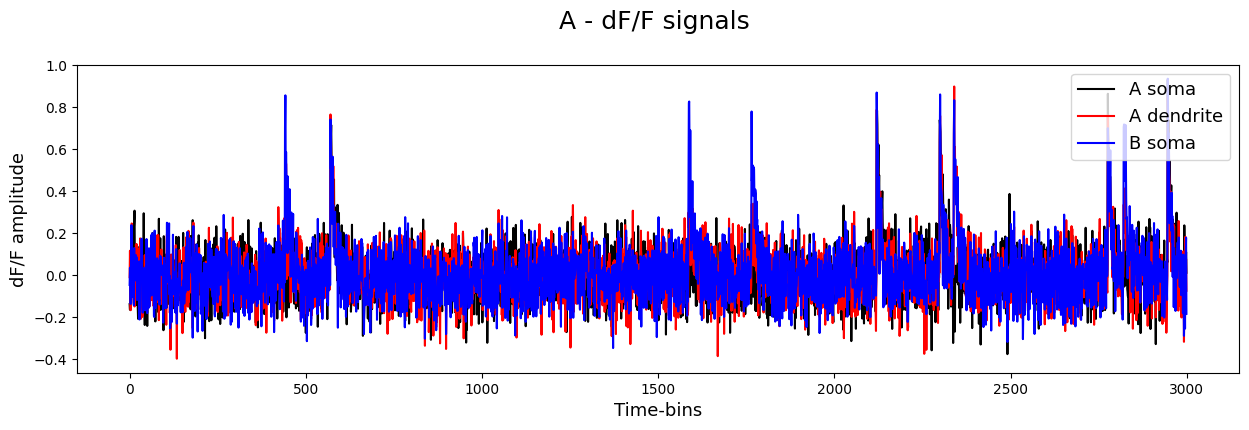

In [23]:
fig0, ax0 = plt.subplots(figsize=(15,4))

colors = ['k','r','b']
for i in range(3):
    ax0.plot(sigs[i][0:3000], color=colors[i])
    ax0.set_title('A - dF/F signals \n', fontsize = 18)
    ax0.legend(labels=['A soma', 'A dendrite', 'B soma'], fontsize = 13, loc = 'upper right')
    ax0.set_xlabel('Time-bins', fontsize = 13)
    ax0.set_ylabel('dF/F amplitude', fontsize = 13)

## Measuring noise

In the next cell I extract (by the time angle) the standard deviation and the mean of random pixels (3) then take their mean. It is important that pixel coordinates need to fall out of the neural compartment masks, so we can assume that the extracted signal represents the noise.

In [24]:
M = 100
noise_m_and_std = np.zeros((2, M))
noise_ij = np.zeros((2, M))
for m in np.arange(M):
    j = np.random.randint(52,98) 
    i = np.random.randint(5,50)
    noise_m_and_std[0,m] = np.mean(dF[i,j,:])
    noise_m_and_std[1,m] = np.std(dF[i,j,:])
    noise_ij[:,m] = [i,j]
print(np.mean(noise_m_and_std, axis=1))

[399.94285808  59.96504598]


Density of noise signals:

Text(0, 0.5, 'Estimated number of standard deviation values')

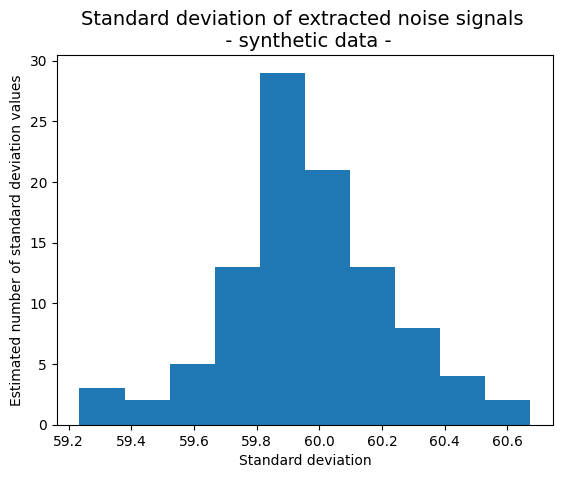

In [25]:
plt.hist(noise_m_and_std[1])
plt.title('Standard deviation of extracted noise signals \n - synthetic data -', fontsize = 14)
plt.xlabel('Standard deviation')
plt.ylabel('Estimated number of standard deviation values')

Both values are close to the values extraced from real data.

In [26]:
# function for plotting the noise pixels on the total view of synthetic data

def Noise_pixel_plot(pic, add_points = None):
    fig0, ax2 = plt.subplots()
    ax2.matshow(pic)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    if (add_points is not None):
            ax2.scatter(add_points[1,:], add_points[0,:], color="white", marker="+")

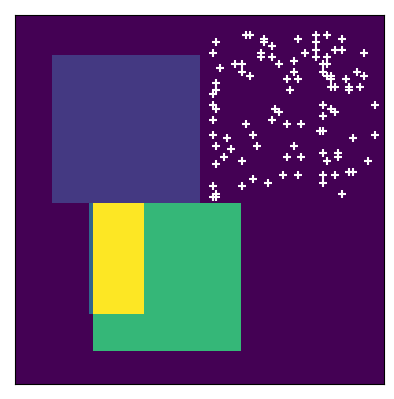

In [27]:
# plot
Noise_pixel_plot(masks, noise_ij)

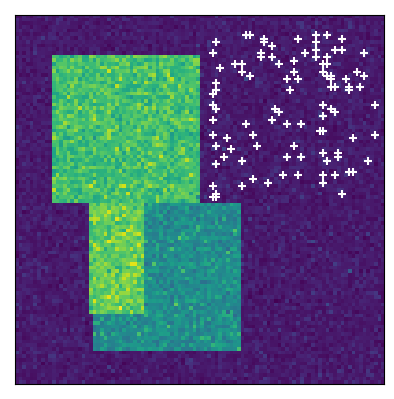

In [28]:
maxIm = np.max(dF, axis=2)
Noise_pixel_plot(maxIm, noise_ij)

In [29]:
def ExpSD(sigE, mask):
    signal = np.array(sigE)
    N = len(mask[1])
    expSD = 56 / np.sqrt(N)
    print(np.std(sigE[0:200]))
    print(expSD)

Next I measure the SE of each synthetic ROI and the SD of an arbitrary period of each generated fluorescent signal.

In [30]:
ExpSD(df_sigs[0],a_soma_mask)

44.832775454320696
1.4


In [31]:
ExpSD(df_sigs[1],a_dend_mask)

44.109749746084134
2.6398653164297774


In [32]:
ExpSD(df_sigs[2],b_soma_mask)

44.0409431779004
1.4


The SE of each and the SD values on signals are quite similar to the values calculated on real data, however SD values of random pixels are way larger due to smaller total pixel size.

In [33]:
df_std = np.std(df_sigs)
noise_m_and_s_var = np.mean(noise_m_and_std, axis=1)
noise_std = noise_m_and_s_var[1]
df_snr = df_std/noise_std
df_snr

0.9906812294266449

## Gauss smoothing

In order to keep the original shape of the signals I needed to implement a function that adds the first and the last values of the original data array to the begining and to the end of the array in a range that is always the half and minus 1 long to a given N (odd) length convolution kernel. 

In [34]:
# function for replacing the first five and last five values of the array with 5th and the 1495th value
# convolving kernel supposed to have the target data point at the middle

def prepare_for_conv(signal_for_gauss, kernel_length):
    N = len(signal_for_gauss)
    if (kernel_length % 2) == 0:
        return ('Kernel length is even.')
    K = int((kernel_length - 1)/2) # must be even in order to have the target data point at the middle
    empty = np.zeros(N + 2*K) 
    signal_start = signal_for_gauss[0]
    signal_end = signal_for_gauss[-1]
    empty[0:K] =  signal_start
    empty[-K:] = signal_end
    empty[K:(N+K)] = signal_for_gauss
    return empty

In [35]:
signal1 = prepare_for_conv(sigs[0], 15)
signal2 = prepare_for_conv(sigs[1], 15)
signal3 = prepare_for_conv(sigs[2], 15)

Defining a 15 length Gauss kernel:

Gauss-kernel: 

\begin{align}
        g(x) = \frac{1}{\sqrt{2\pi\sigma}} * exp^{-x^2/(2\sigma^2)}
    \end{align}

Text(0.5, 1.0, 'Smoothing Gauss-kernel')

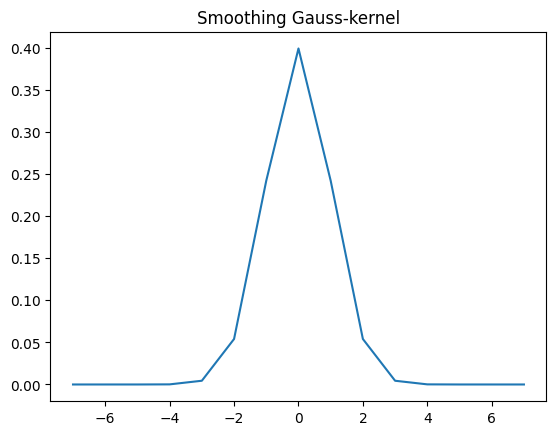

In [36]:
# 16 long gauss convolutional kernel

x = np.arange(-7,8,1)
sigma = 1
normal = 1 / (2.0 * np.pi * sigma**2)
gauss_kernel_beta =  np.exp(-((x**2) / (2.0*sigma**2))) * normal
gauss_kernel = gauss_kernel_beta / np.sum(gauss_kernel_beta)
plt.plot(x,gauss_kernel)
plt.title('Smoothing Gauss-kernel')

Text(0.5, 0.98, 'dF/F and smoothened dF/F signals of each neural compartment')

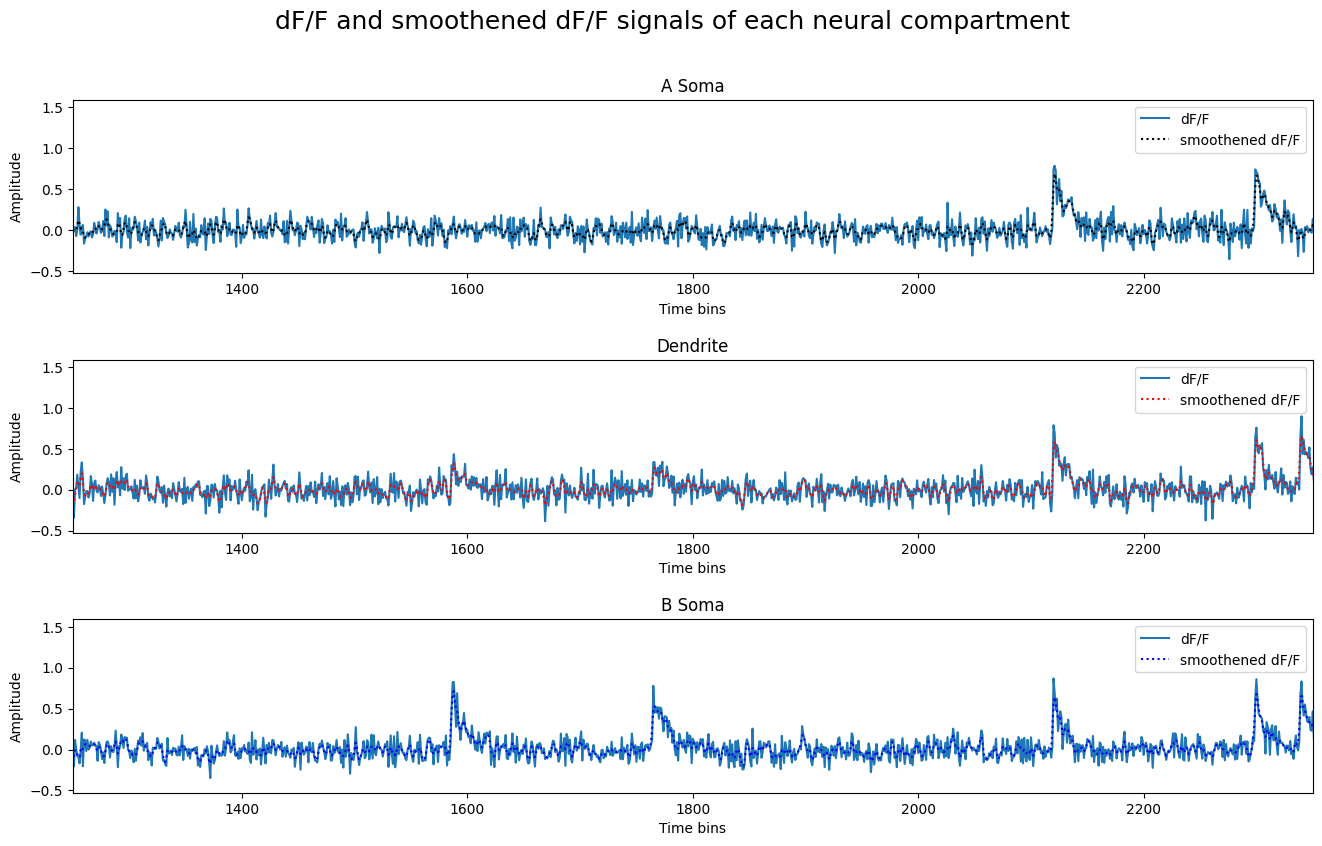

In [37]:
# plotting the gauss smoothed signals

a_events_smooth = np.convolve(signal1,gauss_kernel, mode='valid')
dendritic_events_smooth = np.convolve(signal2,gauss_kernel, mode='valid')
b_events_smooth = np.convolve(signal3,gauss_kernel, mode='valid')

fig, axs = plt.subplots(3, 1,figsize=(16,9), sharey=True)
plt.subplots_adjust(hspace=0.5)

axs[0].plot(sigs[0], label = 'dF/F')
axs[0].plot(a_events_smooth, ':k', label = 'smoothened dF/F')
axs[1].plot(sigs[1], label = 'dF/F')
axs[1].plot(dendritic_events_smooth, ':r', label = 'smoothened dF/F')
axs[2].plot(sigs[2], label = 'dF/F')
axs[2].plot(b_events_smooth, ':b', label = 'smoothened dF/F')
axs[0].title.set_text('A Soma')
axs[1].title.set_text('Dendrite')
axs[2].title.set_text('B Soma')
axs[0].set_xlabel('Time bins')
axs[1].set_xlabel('Time bins')
axs[2].set_xlabel('Time bins')
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Amplitude')
axs[2].set_ylabel('Amplitude')
axs[0].set_xlim(1250,2350)
axs[1].set_xlim(1250,2350)
axs[2].set_xlim(1250,2350)
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('dF/F and smoothened dF/F signals of each neural compartment', fontsize=18)

Average signal:

In [38]:
# avg_signal = (df_sigs[0] + df_sigs[1] + df_sigs[2])/3

# plt.plot((avg_signal[0:1000]), 'r')
# plt.title('Average signal - synthetic data', fontsize = 17)
# plt.xlabel('Signal length (time-bins)', fontsize = 13)
# plt.ylabel('Amplitude', fontsize = 13)

## Event detection

Event detection function that detects the events above a specific threshold (theta_upper) and assign a decay period to it, which is remaining part of the signal array until it reaches a secondary threshold (theta_lower). Theta lower is set below the signal orginal signal detector. The function uses a simple way to detect specific events: When the signal reaches the threshold, the function observes whether the N-1th element is lower then the event threshold and the Nth element is higher, so it returns TRUE. If this is not the signal must not be detected so signal did not go above theta_upper, however it did not go above theta_lower, whihc means it is stll a decay period and rmust return FALSE.

In [39]:
#contains an indented block

def event_detector(signal, theta_upper = 1.65, theta_lower = 1.6): 
    
    N = len(signal)
    
    event = np.zeros(N)
    
    refr = 1
    
    for i in np.arange(1,N):
        if ((signal[i] > theta_upper) and (signal[i-1] < theta_upper) and (refr == 0)):
            event[i] = 1 
            refr = 1
        if (signal[i]<theta_lower):
            refr = 0  
            
    return event

In [40]:
sig1_event = event_detector(a_events_smooth, .25, .1)
sig2_event = event_detector(dendritic_events_smooth, .25, .1)
sig3_event = event_detector(b_events_smooth, .25, .1)

In [41]:
# t_new = len(sig1_event)
# time_unit = (Tmax/nBins)*t_new*1000 # 15 min timebin
# msec = np.linspace(0,time_unit,t_new)

In [1]:
# fig, axs = plt.subplots(3, 1,figsize=(16,9))
# plt.subplots_adjust(hspace=0.5)

# x = msec

# axs[0].plot(x,sig1_event, color='k')
# axs[1].plot(x,sig2_event, color='r')
# axs[2].plot(x,sig3_event, color='b')
# axs[0].title.set_text('A Soma')
# axs[1].title.set_text('Dendrite')
# axs[2].title.set_text('B Soma')

Plot the smoothened signals, the detected events and the original spikes:

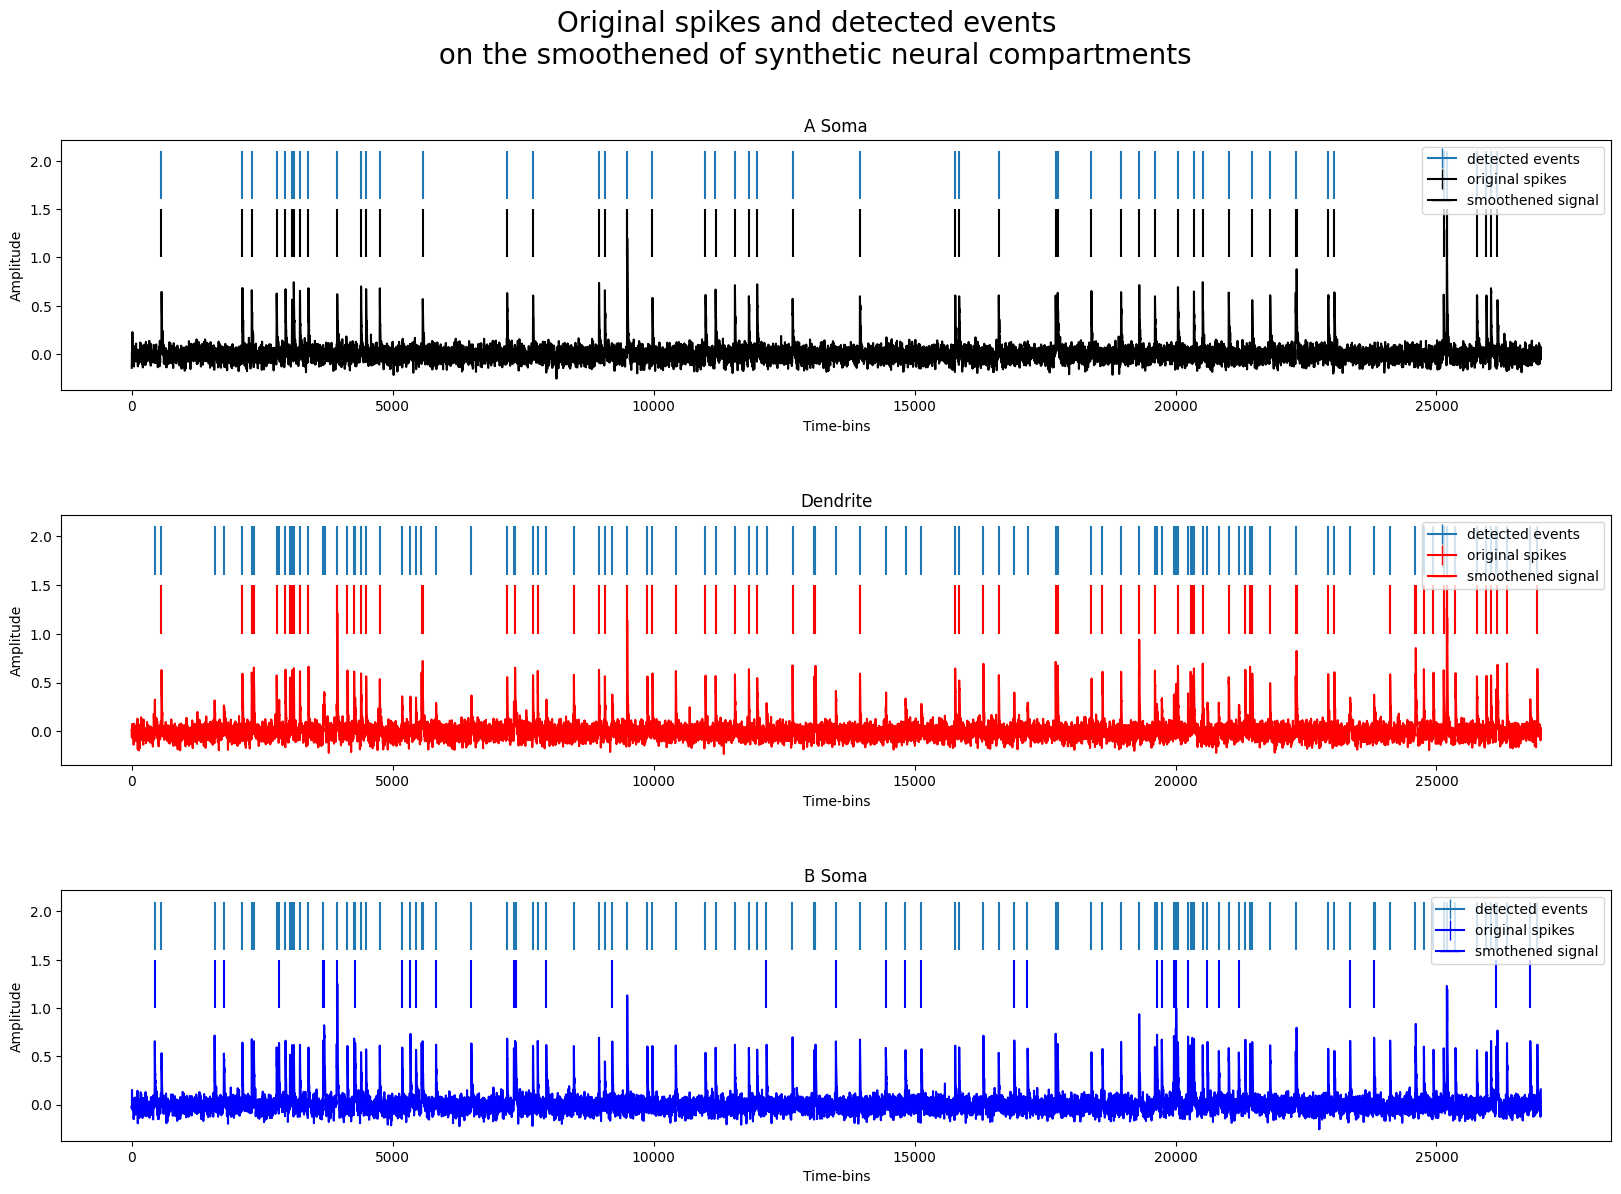

In [43]:
#%matplotlib
import matplotlib.lines as mlines

fig, axs = plt.subplots(3, 1,figsize=(20,13))
plt.subplots_adjust(hspace=0.5)

#plots

axs[0].vlines(np.flatnonzero(spikes_a), 1, 1.5, 'k',  label='Inline label')
axs[1].vlines(np.flatnonzero(spikes_a+spikes_a_dend), 1, 1.5, 'r')
axs[2].vlines(np.flatnonzero(spikes_b), 1, 1.5, 'b')

# # axs[0].plot(sigs[0])
axs[0].plot(a_events_smooth, color='k')
axs[0].vlines(np.flatnonzero(sig1_event), 1.6, 2.1)


# # axs[1].plot(sigs[1])
axs[1].plot(dendritic_events_smooth, color='r')
axs[1].vlines(np.flatnonzero(sig2_event), 1.6, 2.1)

# # axs[2].plot(sigs[2])
axs[2].plot(b_events_smooth, color='b')
axs[2].vlines(np.flatnonzero(sig3_event), 1.6, 2.1)

#basic line

basic_line = mlines.Line2D([], [], marker='|',
                          markersize=15, label='detected events')
# #vlines

black_line = mlines.Line2D([], [], color = 'k', marker='|',
                          markersize=15, label='original spikes')

red_line = mlines.Line2D([], [], color = 'red', marker='|',
                          markersize=15, label='original spikes')

blue_line = mlines.Line2D([], [], color = 'blue', marker='|',
                          markersize=15, label='original spikes')

# #hlines

Hblack_line = mlines.Line2D([], [], color = 'k', marker='_',
                          markersize=15, label='smoothened signal')

Hred_line = mlines.Line2D([], [], color = 'red', marker = '_',
                          markersize=15, label='smoothened signal')

Hblue_line = mlines.Line2D([], [], color = 'blue', marker='_',
                          markersize=15, label='smothened signal')


axs[0].title.set_text('A Soma')
axs[1].title.set_text('Dendrite')
axs[2].title.set_text('B Soma')
# axs[0].set_xlim(0,2500) #2150, 3150
# axs[1].set_xlim(0,2500)
# axs[2].set_xlim(0,2500)
axs[0].set_xlabel('Time bins')
axs[1].set_xlabel('Time bins')
axs[2].set_xlabel('Time bins')
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Amplitude')
axs[2].set_ylabel('Amplitude')
axs[0].legend(handles=[basic_line, black_line, Hblack_line], loc='upper right')
axs[1].legend(handles=[basic_line, red_line, Hred_line], loc='upper right')
axs[2].legend(handles=[basic_line, blue_line, Hblue_line], loc='upper right')

fig.suptitle('Original spikes and detected events \n on the smoothened signal of synthetic neural compartments', fontsize=20)
plt.savefig('events.png')

Save data of every phase of synthetic data generation:

In [44]:
# synthetic_dF0 = np.save('synthetic_dF0', dF0)

# synthetic_dF = np.save('synthetic_dF', dF)

# synthetic_a_soma_signal_smooth = np.save('synthetic_a_soma_signal_smooth', a_events_smooth)
# synthetic_a_dendrite_signal_smooth = np.save('synthetic_a_dendrite_signal_smooth', dendritic_events_smooth)
# synthetic_b_soma_signal_smooth = np.save('synthetic_b_soma_signal_smooth', b_events_smooth)

# synthetic_somatic_event1 = np.save('synthetic_somatic_event1', sig1_event)
# synthetic_dendritic_event = np.save('synthetic_dendritic_event', sig2_event)
# synthetic_somatic_event2 = np.save('synthetic_somatic_event2', sig3_event)

# synthetic_spikes_a_dendrite  = spikes_a+spikes_a_dend
# synthetic_spikes_a_soma = np.save('synthetic_spikes_a_soma', spikes_a)
# synthetic_spikes_a_dendrite = np.save('synthetic_spikes_a_dendrite', synthetic_spikes_a_dendrite)
# synthetic_spikes_b_soma = np.save('synthetic_spikes_b_soma', spikes_b)

# synthetic_a_soma_roi = np.save('synthetic_a_soma_roi',a_soma)
# synthetic_a_dendrite_roi = np.save('synthetic_a_dendrite_roi',dendrites)
# synthetic_b_soma_roi = np.save('synthetic_b_soma_roi',b_soma)

# synthetic_raw_signal_a_soma = np.save('synthetic_raw_signal_a_soma',sigs[0])
# synthetic_raw_signal_a_dendrite = np.save('synthetic_raw_signal_a_dendrite',sigs[1])
# synthetic_raw_signal_b_soma= np.save('synthetic_raw_signal_b_soma',sigs[2])